<a href="https://colab.research.google.com/github/DatCoder21/ETHUSDT_Trading_Strategy/blob/main/Finpros.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install backtrader
!pip install pandas_ta
!pip install xgboost
!pip install backtrader_indicators


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 MB 16.1 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully un

ERROR: Could not find a version that satisfies the requirement backtrader_indicators (from versions: none)
ERROR: No matching distribution found for backtrader_indicators


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas_ta as ta
%matplotlib inline
import backtrader as bt
import math



In [2]:
#Đọc file csv
df = pd.read_csv("/content/ETHUSDT.csv")

In [3]:
df.head()

,timestamp,open,high,low,close,volume
0,2019-11-27 07:30:00,146.00,146.00,146.00,146.00,0.01
1,2019-11-27 08:00:00,125.03,125.03,125.03,125.03,0.01
2,2019-11-27 08:30:00,145.00,145.01,133.00,133.00,0.07
3,2019-11-27 09:00:00,133.00,133.00,133.00,133.00,0.00
4,2019-11-27 09:30:00,133.00,133.00,133.00,133.00,0.00


In [4]:
#Tạo 1 bản sao để tạo data train moldel
df1 = df

In [5]:
#Thêm các cột features để train model
df1['rsi'] = ta.rsi(close=df['close'], length=20)

bb = ta.bbands(close=np.log1p(df['close']), length=20)
df1['bb_low'] = bb.iloc[:, 0]
df1['bb_mid'] = bb.iloc[:, 1]
df1['bb_high'] = bb.iloc[:, 2]

df1['macd'] = ta.macd(close=df['close'], length=20).iloc[:, 0]


In [6]:
#Loại bỏ những giá trị đầu bị NaN vì chưa đủ ít nhất 20 data
df1 = df1.iloc[25:]
df1.head()

,timestamp,open,high,low,close,volume,rsi,bb_low,bb_mid,bb_high,macd
25,2019-11-27 20:00:00,153.84,155.12,153.80,154.59,4402.40,10.889370,4.969639,5.016428,5.063216,5.436190
26,2019-11-27 20:30:00,154.60,155.66,152.91,153.23,4843.92,10.778974,4.978434,5.019991,5.061548,5.160528
27,2019-11-27 21:00:00,153.13,153.56,152.70,153.12,4745.02,10.769678,4.985569,5.022945,5.060320,4.876969
28,2019-11-27 21:30:00,153.12,153.71,152.03,153.44,3993.48,11.004699,4.989676,5.025217,5.060757,4.624757
29,2019-11-27 22:00:00,153.29,154.29,153.00,153.66,3697.02,11.174010,4.992062,5.027007,5.061952,4.392001


In [7]:
#Kiểm tra xem còn NaN không
df1.isna().sum()

,0
timestamp,0
open,0
high,0
low,1
close,1
volume,1
rsi,0
bb_low,1
bb_mid,1
bb_high,1


In [8]:
#Tạo label cho bảng. 0 là dự đoán giảm, 1 là dự đoán tăng
df1['target'] = (df1['close'].shift(-1) > df1['close']).astype(int)

In [9]:
df1

,timestamp,open,high,low,close,volume,rsi,bb_low,bb_mid,bb_high,macd,target
25,2019-11-27 20:00:00,153.84,155.12,153.80,154.59,4402.400,10.889370,4.969639,5.016428,5.063216,5.436190,0
26,2019-11-27 20:30:00,154.60,155.66,152.91,153.23,4843.920,10.778974,4.978434,5.019991,5.061548,5.160528,0
27,2019-11-27 21:00:00,153.13,153.56,152.70,153.12,4745.020,10.769678,4.985569,5.022945,5.060320,4.876969,1
28,2019-11-27 21:30:00,153.12,153.71,152.03,153.44,3993.480,11.004699,4.989676,5.025217,5.060757,4.624757,1
29,2019-11-27 22:00:00,153.29,154.29,153.00,153.66,3697.020,11.174010,4.992062,5.027007,5.061952,4.392001,0
...,...,...,...,...,...,...,...,...,...,...,...,...
85457,2024-10-11 16:00:00,2442.36,2448.47,2437.27,2443.07,65718.366,69.152922,7.781667,7.791881,7.802095,10.851340,0
85458,2024-10-11 16:30:00,2443.07,2447.65,2433.59,2437.01,68552.708,64.305703,7.781927,7.792430,7.802933,10.668064,1
85459,2024-10-11 17:00:00,2437.01,2439.97,2432.00,2439.20,23585.597,65.232747,7.782259,7.793028,7.803797,10.577599,1
85460,2024-10-11 17:30:00,2439.21,2451.98,2439.20,2448.50,84029.301,68.849224,7.782619,7.793893,7.805167,11.128059,0


**Moldel**

In [10]:
#Chia tập train 80%, và test 20%
train_size = int(len(df1)*0.8)
train = df1.iloc[:train_size]
test = df1.iloc[train_size:]

In [11]:
#Tạo X (Xóa cột target) và y (Chỉ có cột target)
x = df1.drop("target", axis=1)

features = x.columns
X_train = train[features]
y_train = train["target"]
X_test = test[features]
y_test = test["target"]

In [12]:
#Sử dụng model XGBoostClassifier để train
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
X_train_numeric = X_train.drop('timestamp', axis=1)
X_test_numeric = X_test.drop('timestamp', axis=1)
model.fit(X_train_numeric, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [11:47:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [13]:
#Accuracy
preds = model.predict(X_test_numeric)
test_acc = model.score(X_test_numeric, y_test)
print(test_acc)

0.5199555243445693


In [14]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.51      0.48      0.49      8356
           1       0.53      0.56      0.54      8732

    accuracy                           0.52     17088
   macro avg       0.52      0.52      0.52     17088
weighted avg       0.52      0.52      0.52     17088



In [15]:
conf_mat = confusion_matrix(y_test, preds)
conf_mat

array([[3997, 4359],
       [3844, 4888]])

In [16]:
accuracy_score(y_test, preds)

0.5199555243445693

In [17]:
#Lưu model để tái sử dụng
from joblib import dump, load
dump(model, 'model.joblib')
model1 = load('model.joblib')

In [18]:
#Test thử model
input_data = [[153.84, 155.12, 153.80, 154.59, 4402.400, 10.889370, 4.969639, 5.016428, 5.063216, 5.436190]]
input_df = pd.DataFrame(input_data, columns=X_train_numeric.columns)
model1.predict(input_df)

array([0])

**BackTest**

In [19]:
#Định nghĩa chỉ báo OBV
import backtrader as bt

class OBV(bt.Indicator):
    lines = ('obv',)
    plotinfo = dict(subplot=True)
    plotlines = dict(obv=dict(color='blue'))

    def __init__(self):
        self.addminperiod(2)

    def next(self):
        if self.data.close[0] > self.data.close[-1]:
            self.lines.obv[0] = self.lines.obv[-1] + self.data.volume[0]
        elif self.data.close[0] < self.data.close[-1]:
            self.lines.obv[0] = self.lines.obv[-1] - self.data.volume[0]
        else:
            self.lines.obv[0] = self.lines.obv[-1]


In [20]:
#Định nghĩa chỉ báo OBV
import backtrader as bt

class OBV(bt.Indicator):
    lines = ('obv',)
    plotinfo = dict(subplot=True)
    plotlines = dict(obv=dict(color='blue'))

    def __init__(self):
        self.addminperiod(2)

    def next(self):
        if self.data.close[0] > self.data.close[-1]:
            self.lines.obv[0] = self.lines.obv[-1] + self.data.volume[0]
        elif self.data.close[0] < self.data.close[-1]:
            self.lines.obv[0] = self.lines.obv[-1] - self.data.volume[0]
        else:
            self.lines.obv[0] = self.lines.obv[-1]


In [31]:
#Định nghĩa Strategy
class Strategy(bt.Strategy):
    params = dict(
        fast=50,
        slow=200,
        order_percentage=0.95,
        ticker='SPY'
    )

    #Tạo hàm khởi tạo để định nghĩa các tham số
    def __init__(self):
        self.dataclose = self.datas[0].close

        self.order = None
        self.buyprice = None
        self.buycomm = None

        self.rsi = bt.indicators.RSI(self.datas[0], period=20)
        self.bb = bt.indicators.BollingerBands(self.datas[0], period=20)
        self.macd = bt.indicators.MACD(self.datas[0])
        self.adx = bt.indicators.ADX(self.datas[0], period=14)
        self.obv = OBV(self.datas[0])

        # Đường trung bình động nhanh (50 ngày)
        self.fast_moving_average = bt.indicators.SMA(
            self.data.close, period=self.params.fast, plotname='50-day SMA'
        )

        # Đường trung bình động chậm (200 ngày)
        self.slow_moving_average = bt.indicators.SMA(
            self.data.close, period=self.params.slow, plotname='200-day SMA'
        )

        # Tín hiệu giao cắt (Golden Cross / Death Cross)
        self.crossover = bt.indicators.CrossOver(
            self.fast_moving_average, self.slow_moving_average
        )

    def next(self):
        #Định nghĩa các tham số để dự báo giá close
        open_ = self.data.open[0]
        high = self.data.high[0]
        low = self.data.low[0]
        close = self.data.close[0]
        vol = self.data.volume[0]
        rsi_val = self.rsi[0]
        bb_low = self.bb.lines.bot[0]
        bb_mid = self.bb.lines.mid[0]
        bb_high = self.bb.lines.top[0]
        macd_val = self.macd.macd[0]
        adx_val = self.adx[0]
        obv_val_0 = self.obv[0]
        obv_val_1 = self.obv[-1]

        # Hiển thị giá sau mỗi 1 cây nến
        dt = self.datas[0].datetime.date(0)
        print(f"[{dt}] Close:{close:.2f}")

        # Định nghĩa xu hướng. Nếu sau 3 phiên mà đều tăng hoặc giảm thì sẽ là 1 xu hướng
        trend_period = 3
        trend = 'sideway'
        if len(self) > trend_period:
            if all(self.dataclose[i] > self.dataclose[i-1] for i in range(-trend_period + 1, 1)):
                trend = 'up'
            elif all(self.dataclose[i] < self.dataclose[i-1] for i in range(-trend_period + 1, 1)):
                trend = 'down'

        #Tạo data frame để dự báo giá bằng model XGBoostClassification
        input_data = [[
            open_, high, low, close, vol, rsi_val, bb_low, bb_mid, bb_high, macd_val
        ]]
        input_df = pd.DataFrame(input_data, columns=X_train_numeric.columns)
        prediction = model1.predict(input_df)[0]

        #Khi chưa mua
        if self.position.size == 0:
            #Điều kiện mua khi thỏa mãn 1 trong những điều kiện
            if prediction == 1 or self.crossover > 0 or trend == 'up' or  (adx_val > 25):
                amount_to_invest = self.params.order_percentage * self.broker.cash
                self.size = math.floor(amount_to_invest / close)

                print(f"Buy {self.size} shares of {self.params.ticker} at {close:.2f}")
                self.buy(size=self.size)

        elif self.position.size > 0:
            current_price = self.dataclose[0]
            average_price = self.position.price

            #Cắt lỗ khi mất 20% giá
            if current_price <= average_price * 0.80:
                print(f"Sell Loss {self.size} shares of {self.params.ticker} at {close:.2f}")
                self.order = self.sell(size=self.position.size)

            # Điều kiện bán khi thỏa mãn tất cả các yêu cầu
            elif (self.crossover < 0
                and ((self.rsi[0] > 70)
                and ((close > self.bb.lines.top[0])
                and (self.macd.macd[0] < 0)))
                and trend == 'down'
                and (adx_val < 20)
                and (obv_val_0 == obv_val_1 - obv_val_0)
            ):
                print(f"Sell {self.size} shares of {self.params.ticker} at {close:.2f}")
                self.close()


In [32]:
cerebro = bt.Cerebro()

In [33]:
feed = bt.feeds.PandasData(dataname=df, datetime='timestamp')

In [34]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [35]:
cerebro.adddata(feed)

In [36]:
cerebro.addstrategy(Strategy)

0

In [37]:
cerebro.broker.setcommission(commission=0.005)

In [38]:
cerebro.addsizer(bt.sizers.PercentSizer, percents=50)

In [39]:
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name='sharpe')
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name='areturn')
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trade')

In [40]:
teststrat = cerebro.run()

Streaming output truncated to the last 5000 lines.
[2024-06-29] Close:3386.84
[2024-06-29] Close:3385.60
[2024-06-29] Close:3393.46
[2024-06-29] Close:3384.00
[2024-06-29] Close:3385.39
[2024-06-29] Close:3385.98
[2024-06-29] Close:3388.14
[2024-06-29] Close:3384.73
[2024-06-29] Close:3389.00
[2024-06-29] Close:3387.12
[2024-06-29] Close:3386.20
[2024-06-29] Close:3386.78
[2024-06-29] Close:3383.00
[2024-06-29] Close:3383.92
[2024-06-29] Close:3387.00
[2024-06-29] Close:3380.90
[2024-06-29] Close:3375.59
[2024-06-29] Close:3378.96
[2024-06-29] Close:3377.62
[2024-06-30] Close:3385.00
[2024-06-30] Close:3384.93
[2024-06-30] Close:3381.67
[2024-06-30] Close:3375.21
[2024-06-30] Close:3366.07
[2024-06-30] Close:3361.19
[2024-06-30] Close:3365.42
[2024-06-30] Close:3370.31
[2024-06-30] Close:3365.00
[2024-06-30] Close:3362.36
[2024-06-30] Close:3361.82
[2024-06-30] Close:3366.06
[2024-06-30] Close:3368.68
[2024-06-30] Close:3376.60
[2024-06-30] Close:3393.28
[2024-06-30] Close:3393.06
[202

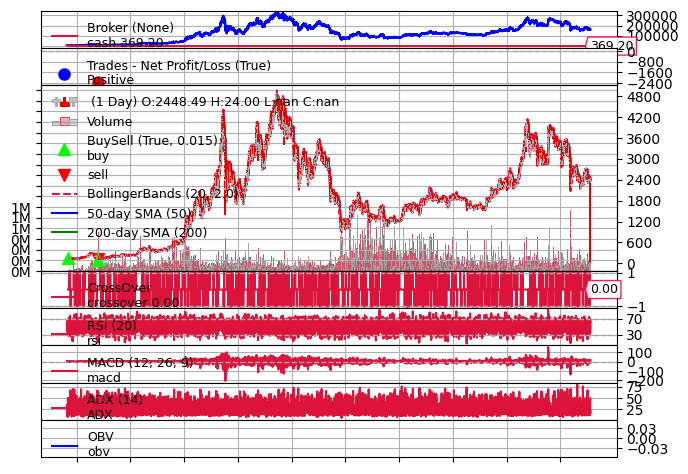

[[<Figure size 640x480 with 9 Axes>]]

In [41]:
%matplotlib inline
cerebro.plot(
    style='candlestick',
    volume=True,
    iplot=False,
    figsize=(12, 6),
)

In [42]:
from pprint import pprint

strat = teststrat[0]

print("Sharpe Ratio:")
pprint(strat.analyzers.sharpe.get_analysis())

print("\nAnnual Return (%):")
pprint(strat.analyzers.areturn.get_analysis())

print("\nTổng lợi nhuận:")
pprint(strat.analyzers.returns.get_analysis())

print("\nDrawdown:")
pprint(strat.analyzers.drawdown.get_analysis())

print("\nTrade Stats:")
pprint(strat.analyzers.trade.get_analysis())


Sharpe Ratio:
OrderedDict({'sharperatio': nan})

Annual Return (%):
OrderedDict([(2019, -0.12048672000000005),
             (2020, 4.741598694223242),
             (2021, 3.9573835249282423),
             (2022, -0.6736259806684279),
             (2023, 0.905304480614004),
             (2024, nan)])

Tổng lợi nhuận:
OrderedDict({'rtot': nan, 'ravg': nan, 'rnorm': nan, 'rnorm100': nan})

Drawdown:
AutoOrderedDict([('len', 51171),
                 ('drawdown', nan),
                 ('moneydown', nan),
                 ('max',
                  AutoOrderedDict([('len', 51171),
                                   ('drawdown', 81.33736096417577),
                                   ('moneydown', 268665.95999999996)]))])

Trade Stats:
AutoOrderedDict([('total',
                  AutoOrderedDict({'total': 2, 'open': 1, 'closed': 1})),
                 ('streak',
                  AutoOrderedDict([('won',
                                    AutoOrderedDict([('current', 0),
                     